# setup

```
pipenv install notebook numpy delphi-epidata matplotlib
pipenv run jupyter notebook
```

# process-agnostic signal prediction

Ground truth is the timeline of who is infected. Data is far separated from ground truth by a number of confounding pathways. For example, case data:

- some infections are asymptomatic
- not all symptomatic infections result in medical diagnosis
- diagnosis happens with some delay distribution, usually, but not always, following symptom onset
- reporting happens with some delay distribution which appears to vary by day of week
- holidays (etc) influence help-seeking and reporting behavior
- behavior changes over time (e.g. interventions, "pandemic fatigue")

Nowcasting true infecteds from data like this is a Ridiculously Hard problem. Further, since ground truth is latent, the only way to validate the model is through forecasting.

What about decoupling this into two smaller problems?

1. given laggy and non-final data, predict final data up to current time
2. estimate SIR-like model parameters (which vary over time) given that data

These are still hard problems, but at least the first problem becomes tractable in the sense that we can validate the approach on historcial data. The second problem still must be validated through forecasting, but it is made incrementally easier by having stable, up-to-date data from all sources.

This notebook explores the first problem: process-agnostic signal nowcasting. Each signal (e.g. doctor visits, cases, survey responses) becomes its own ground truth, and each signal is predicted using lagged versions of itself and all other signals.

# the basics

Notebook setup, test API calls and plotting, etc.

In [47]:
# standard library
import datetime

# third party
import matplotlib.pyplot as plt
import numpy as np

# first party
from delphi_epidata import Epidata

# default figure size
plt.rcParams['figure.figsize'] = (9, 6)

In [14]:
# data_source=usa-facts&signals=confirmed_incidence_num&time_type=day&geo_type=state&time_values=20200101-20201026&geo_value=GA
response = Epidata.covidcast('usa-facts', 'confirmed_incidence_num', 'day', 'state', Epidata.range(20200101, 20201026), 'GA')
response['message']

'success'

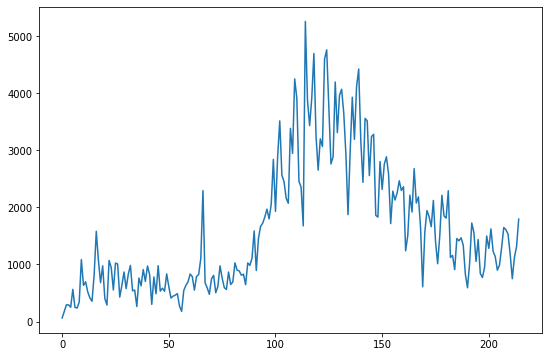

In [164]:
data = [(row['time_value'], row['value']) for row in response['epidata']]
data = sorted(data, key=lambda row: row[0])
data = [row for row in data if row[0] >= 20200322]

values = [row[1] for row in data]
plt.plot(values)
plt.show()

# warmup: just two signals

Let's start out with two signals. The plan is to predict signal-1 on day $t_n$ using signal-1 and signal-2 on days $t_{n-3}$, $t_{n-2}$, and $t_{n-1}$. And we'll also include 7 weekday covariates to absorb some of the weekday effects.

Some notes:

- look at a single state, GA for example
- use vanilla regression with 13 covariates (3 + 3 + 7)
- do in-sample first (optional, not super helpful), followed by out-of-sample (what we really care about)
- when training out-of-sample, want to use weights or sliding window to adapt to changing relationship
- hoping that errors are roughly IID normal
- i don't really trust early data, will pretend all signals start on 2020-03-22

In [198]:
# helper functions

def load_data(source, signal):
    print(source, signal, 'day', 'state', Epidata.range(20200101, 20210101), 'GA')
    response = Epidata.covidcast(source, signal, 'day', 'state', Epidata.range(20200101, 20210101), 'GA')
    if response['result'] != 1:
        raise Exception(response['message'])
    data = [(row['time_value'], row['value']) for row in response['epidata']]
    data = sorted(data, key=lambda row: row[0])
    data = [row for row in data if row[0] >= 20200322]
    return data

def add_days(date, n):
    d = datetime.date(date // 10000, (date // 100) % 100, date % 100)
    d += datetime.timedelta(days=n)
    return d.year * 10000 + d.month * 100 + d.day

def day_of_week(date):
    d = datetime.date(date // 10000, (date // 100) % 100, date % 100)
    return d.weekday()

def rmse(a, b):
    return np.sqrt(np.mean(np.square(np.array(a) - np.array(b))))

In [199]:
sig1 = load_data('usa-facts', 'confirmed_incidence_num')
sig2 = load_data('doctor-visits', 'smoothed_cli')
print(len(sig1), len(sig2))

usa-facts confirmed_incidence_num day state {'from': 20200101, 'to': 20210101} GA
doctor-visits smoothed_cli day state {'from': 20200101, 'to': 20210101} GA
220 218


In [236]:
s1 = dict(sig1)
s2 = dict(sig2)

# sig1 = 3x-sig1 + 3x-sig2 + 7x-weekday
def get_row(date):
    x = [
        s1[add_days(date, -3)],
        s1[add_days(date, -2)],
        s1[add_days(date, -1)],
        s2[add_days(date, -3)],
        s2[add_days(date, -2)],
        s2[add_days(date, -1)],
        int(day_of_week(date) == 0),
        int(day_of_week(date) == 1),
        int(day_of_week(date) == 2),
        int(day_of_week(date) == 3),
        int(day_of_week(date) == 4),
        int(day_of_week(date) == 5),
        int(day_of_week(date) == 6),
    ]
    y = s1[date]
    return x, y

[ 2.84658412e-01  5.72061584e-02  3.95194262e-01  4.21726459e+00
  1.41423145e+02 -4.66728556e+01 -2.25070757e+02  1.53608651e+02
  2.06117166e+01  6.84015676e+01 -3.30274848e+00 -1.12534080e+02
 -4.53830465e+02]
rmse 455.90885071970894


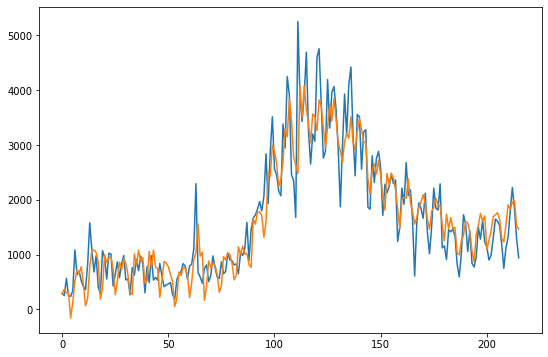

In [237]:
# in-sample fit

x, y = [], []
for date, value in sig1:
    try:
        a, b = get_row(date)
        x.append(a)
        y.append(b)
    except:
        pass

X, Y = np.array(x), np.array(y)

B = np.linalg.inv(X.T @ X) @ X.T @ Y
Yhat = X @ B
print(B.T)
print('rmse', rmse(Y, Yhat))

plt.plot(Y)
plt.plot(Yhat)
plt.show()

[ 2.19565990e-01  1.78092233e-01  1.27006787e-01  3.85670625e+02
 -3.54526870e+02  4.96023031e+01 -4.65996705e+02  2.30703446e+02
  1.25211684e+03  1.60095946e+02  9.21166823e+01  8.05449750e+01
 -4.20059065e+02]


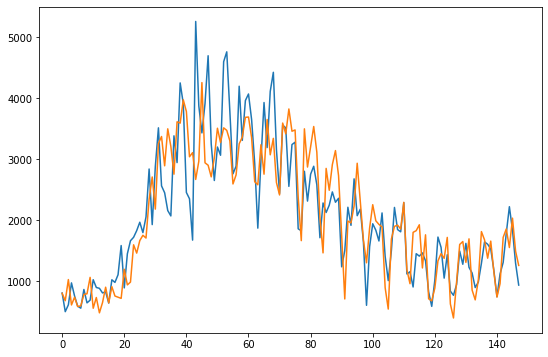

576.5609366212223


In [238]:
# out-of-sample fit

def train(test_date):
    x, y = [], []
    for date, value in sig1:
        if not (add_days(test_date, -45) <= date < test_date):
            continue
        try:
            a, b = get_row(date)
            x.append(a)
            y.append(b)
        except:
            pass
    X, Y = np.array(x), np.array(y)
    B = np.linalg.inv(X.T @ X) @ X.T @ Y
    return B

def test(test_date, B):
    a, b = get_row(test_date)
    X, Y = np.array([a]), np.array([b])
    Yhat = X @ B
    return Y, Yhat

# predict june 1 and on
act, est = [], []
current = 20200601
while current < max(s1.keys()):
    B = train(current)
    Y, Yhat = test(current, B)
    act.append(Y[0])
    est.append(Yhat[0])
    current = add_days(current, 1)

print(B.T)

plt.plot(act)
plt.plot(est)
plt.show()
print(rmse(act, est))

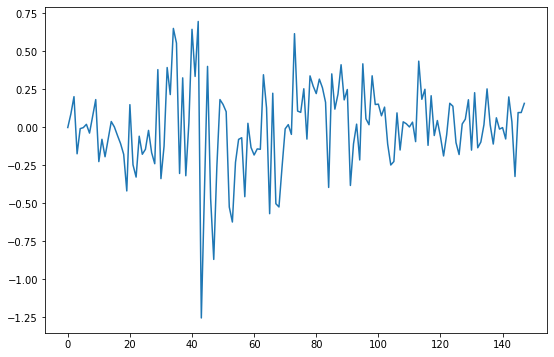

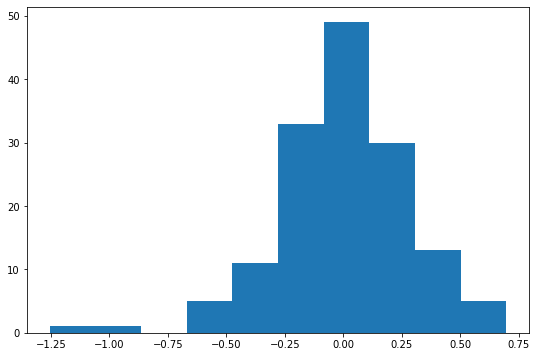

In [239]:
# oos error distribution (relative to signal mean)
err = (np.array(est) - np.array(act)) / np.mean(act)
plt.plot(err)
plt.show()
plt.hist(err)
plt.show()

## thoughts

- it looks like the approach worked (no unexpected artifacts)
- errors are nicely distributed, but much to large to be useful at this point
- some interesting challenges ahead with data missingness
- this is going to get computationally expensive at the county level

You might be wondering what impact the weekday covariates make. By taking them away:

- in-sample rmse: 455 -> 488
- out-of-sample rmse: 576 -> 568
- error distribution: a little less normal-looking

So they're not very helpful here.

# four signals

- `usa-facts` `confirmed_incidence_num`
- `doctor-visits` `smoothed_cli`
- `fb-survey` `raw_cli`
- ~`ght` `raw_search`~
- `quidel` `covid_ag_raw_pct_positive`

Same idea as above, except with more signals and no weekday covariates.

In [242]:
sig1 = dict(load_data('usa-facts', 'confirmed_incidence_num'))
sig2 = dict(load_data('doctor-visits', 'smoothed_cli'))
sig3 = dict(load_data('fb-survey', 'raw_cli'))
sig4 = dict(load_data('ght', 'raw_search'))
print(len(sig1), len(sig2), len(sig3), len(sig4))

usa-facts confirmed_incidence_num day state {'from': 20200101, 'to': 20210101} GA
doctor-visits smoothed_cli day state {'from': 20200101, 'to': 20210101} GA
fb-survey raw_cli day state {'from': 20200101, 'to': 20210101} GA
ght raw_search day state {'from': 20200101, 'to': 20210101} GA
220 218 206 212


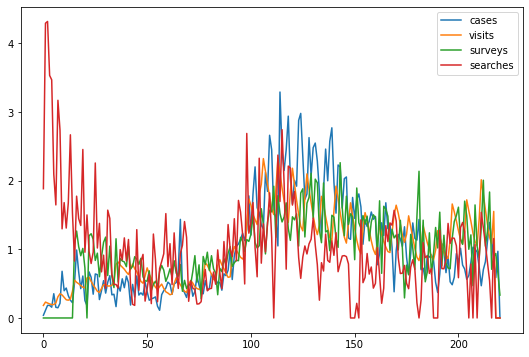

In [252]:
# let's see what we're working with -- signals scaled and plotted
days = sorted(sig1.keys() | sig2.keys() | sig3.keys() | sig4.keys())

def plot_signal(sig, name):
    values = np.array([sig.get(d, 0) for d in days], dtype=np.float)
    values /= np.mean(values)
    plt.plot(values, label=name)

plot_signal(sig1, 'cases')
plot_signal(sig2, 'visits')
plot_signal(sig3, 'surveys')
plot_signal(sig4, 'searches')
plt.legend()
plt.show()

quidel covid_ag_raw_pct_positive day state {'from': 20200101, 'to': 20210101} GA
150


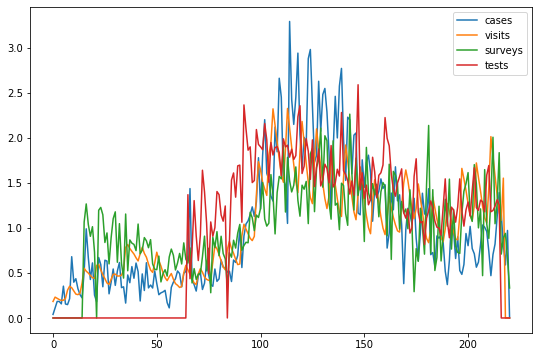

In [255]:
# i'm hesitant to use searches, let's get a different one
sig4 = dict(load_data('quidel', 'covid_ag_raw_pct_positive'))
print(len(sig4))

# let's see what we're working with -- signals scaled and plotted
days = sorted(sig1.keys() | sig2.keys() | sig3.keys() | sig4.keys())

def plot_signal(sig, name):
    values = np.array([sig.get(d, 0) for d in days], dtype=np.float)
    values /= np.mean(values)
    plt.plot(values, label=name)

plot_signal(sig1, 'cases')
plot_signal(sig2, 'visits')
plot_signal(sig3, 'surveys')
plot_signal(sig4, 'tests')
plt.legend()
plt.show()

In [277]:
# predict signal-1 (cases) as linear combination of all signals on last 3 days
def get_row(date):
    x = []
    for sig in (sig1, sig2, sig3, sig4):
        for lag in (-3, -2, -1):
            x.append(sig[add_days(date, lag)])
    return x, sig1[date]

[ 2.62481335e-01  3.30688608e-02  4.15804484e-01  5.13990126e+00
  1.94423397e+02 -3.73221426e+01  8.69824405e+01 -5.83507682e+02
 -1.63427234e+02  1.83683966e+01  1.44511314e+01 -2.61499489e+01]
rmse 522.8269294062071


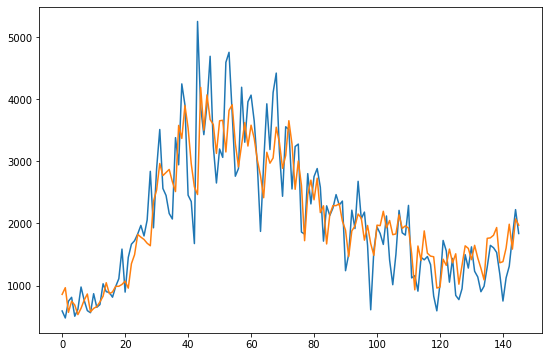

In [278]:
# in-sample fit
x, y = [], []
for date in days:
    try:
        a, b = get_row(date)
        x.append(a)
        y.append(b)
    except:
        pass

X, Y = np.array(x), np.array(y)

B = np.linalg.inv(X.T @ X) @ X.T @ Y
Yhat = X @ B
print(B.T)
print('rmse', rmse(Y, Yhat))

plt.plot(Y)
plt.plot(Yhat)
plt.show()

[ 8.04120328e-02  1.91654115e-01  2.12152568e-01  1.46615983e+02
  1.98533100e+01 -9.47540646e+01 -1.85913037e+01 -1.19920780e+02
 -3.91917280e+01  1.45590927e+02 -1.09732777e+01 -9.02563502e+01]


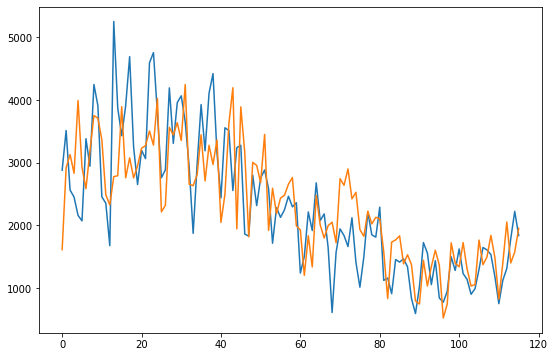

680.8091850737517


In [279]:
# out-of-sample fit

def train(test_date):
    x, y = [], []
    for date, value in sig1.items():
        if not (add_days(test_date, -60) <= date < test_date):
            continue
        try:
            a, b = get_row(date)
            x.append(a)
            y.append(b)
        except:
            pass
    X, Y = np.array(x), np.array(y)
    B = np.linalg.inv(X.T @ X) @ X.T @ Y
    return B

def test(test_date, B):
    a, b = get_row(test_date)
    X, Y = np.array([a]), np.array([b])
    Yhat = X @ B
    return Y, Yhat

# predict july 1 and on
act, est = [], []
current = 20200701
while current < max(s1.keys()):
    B = train(current)
    try:
        Y, Yhat = test(current, B)
        act.append(Y[0])
        est.append(Yhat[0])
    except:
        pass
    current = add_days(current, 1)

print(B.T)

plt.plot(act)
plt.plot(est)
plt.show()
print(rmse(act, est))

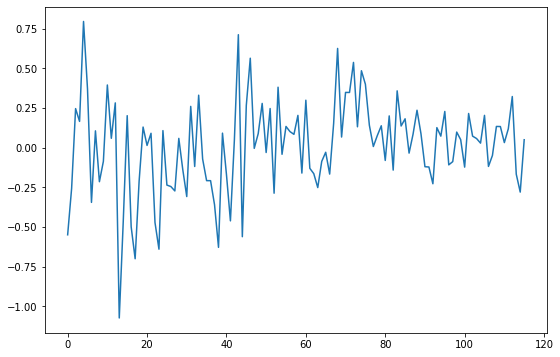

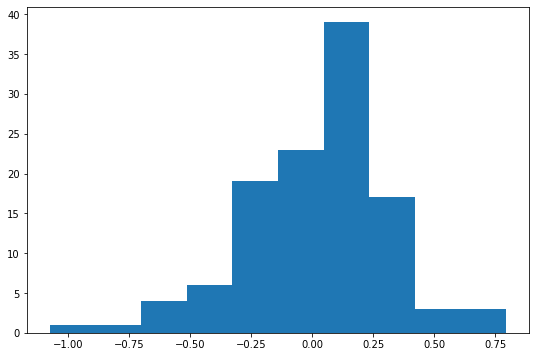

In [280]:
# oos error distribution (relative to signal mean)
err = (np.array(est) - np.array(act)) / np.mean(act)
plt.plot(err)
plt.show()
plt.hist(err)
plt.show()

## thoughts

Disappointingly, error increases with the addition of the two new signals.

# future directions

Here are some thoughts for further things to try.

### regularization

Lack of training data hurts already, and it gets worse with more signals. Something as simple as an L2 penalty might allow adding new signals and more days per signal.

### runtime model construction

These signals are sporadically missing, lagged by up to a week, and are subject to backfill. At runtime, the task is to predict a signal at the current time. The problem is that, in general, we don't know which signals and days are available to use for prediction.

Idea is to take stock of what's available at runtime, say day 215. Maybe it's signal-1 on days 1-209, 211, 214 and signal-2 on days 1-208 and 211-212. Then we train a brand new model using the most recent (say 3) lags for each signal. That is, signal-1 at t-6, t-4, t-1, and signal-2 at t-7, t-4, t-3.

### sensor fusion

Far into the future as we look into assimilating data across geographic areas, sensor fusion might be helpful. For example, not all signals are available at a county level, but we'd still like to use them to inform our nowcasts.